In [1]:
!pip install tensorflow==2.1.0

     |████████████████████████████████| 421.8MB 19kB/s 
     |████████████████████████████████| 450kB 36.9MB/s 
     |████████████████████████████████| 3.9MB 32.0MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=bf410b1d2933471a0d328e5341e5f3d3bcb1d95a0099bbcb519d6d10aec06713
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.10.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: tensorboard 2.2.2
    Uninstalling tensorboard-2.2.2:
      Successfully uninstalled tensorboard-2.2.2
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: 

In [2]:
!pip install tensorflow-quantum

     |████████████████████████████████| 3.9MB 6.1MB/s 
     |████████████████████████████████| 1.4MB 36.8MB/s 
     |████████████████████████████████| 5.3MB 30.6MB/s 
     |████████████████████████████████| 163kB 40.0MB/s 
     |████████████████████████████████| 1.2MB 36.6MB/s 
     |████████████████████████████████| 71kB 8.8MB/s 
     |████████████████████████████████| 112kB 43.2MB/s 
  Created wheel for pathos: filename=pathos-0.2.5-cp36-none-any.whl size=77577 sha256=4ab82daa680795ee2d072932c9cd228efb666e8ab686ab0a9ff38f99fff20e76
  Stored in directory: /root/.cache/pip/wheels/61/6d/83/90b0c3d2c271da2c4850731e894798c98f8dbedbac74e8eff0
  Created wheel for ppft: filename=ppft-1.6.6.1-cp36-none-any.whl size=64708 sha256=b0fec12d7275692ebd2b68a3738ac78f35cb9de4a2f7cb460a261257d191b9b6
  Stored in directory: /root/.cache/pip/wheels/6a/0c/53/ea8dd63608f75c1e7a64d5c5ce5d1e6d04f15ae8a6fce4c2a0
  Created wheel for pox: filename=pox-0.2.7-cp36-none-any.whl size=28303 sha256=a5d96c8bfa3e69c92

In [0]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

In [0]:
qubit = cirq.GridQubit(0, 0)

# Define some circuits.
circuit1 = cirq.Circuit(cirq.X(qubit))
circuit2 = cirq.Circuit(cirq.H(qubit))

# Convert to a tensor.
input_circuit_tensor = tfq.convert_to_tensor([circuit1, circuit2])

# Define a circuit that we want to append
y_circuit = cirq.Circuit(cirq.Y(qubit))

# Instantiate our layer
y_appender = tfq.layers.AddCircuit()

# Run our circuit tensor through the layer and save the output.
output_circuit_tensor = y_appender(input_circuit_tensor, append=y_circuit)

In [5]:
print(tfq.from_tensor(input_circuit_tensor))

[cirq.Circuit([
    cirq.Moment(
        cirq.X(cirq.GridQubit(0, 0)),
    ),
])
 cirq.Circuit([
    cirq.Moment(
        cirq.H(cirq.GridQubit(0, 0)),
    ),
])]


In [6]:
print(tfq.from_tensor(output_circuit_tensor))

[cirq.Circuit([
    cirq.Moment(
        cirq.X(cirq.GridQubit(0, 0)),
    ),
    cirq.Moment(
        cirq.Y(cirq.GridQubit(0, 0)),
    ),
])
 cirq.Circuit([
    cirq.Moment(
        cirq.H(cirq.GridQubit(0, 0)),
    ),
    cirq.Moment(
        cirq.Y(cirq.GridQubit(0, 0)),
    ),
])]


In [0]:
def generate_data(qubits):
    """Generate training and testing data."""
    n_rounds = 20  # Produces n_rounds * n_qubits datapoints.
    excitations = []
    labels = []
    for n in range(n_rounds):
        for bit in qubits:
            rng = np.random.uniform(-np.pi, np.pi)
            excitations.append(cirq.Circuit(cirq.rx(rng)(bit)))
            labels.append(1 if (-np.pi / 2) <= rng <= (np.pi / 2) else -1)

    split_ind = int(len(excitations) * 0.7)
    train_excitations = excitations[:split_ind]
    test_excitations = excitations[split_ind:]

    train_labels = labels[:split_ind]
    test_labels = labels[split_ind:]

    return tfq.convert_to_tensor(train_excitations), np.array(train_labels), \
        tfq.convert_to_tensor(test_excitations), np.array(test_labels)

In [8]:
sample_points, sample_labels, _, __ = generate_data(cirq.GridQubit.rect(1, 4))
print('Input:', tfq.from_tensor(sample_points)[0], 'Output:', sample_labels[0])
print('Input:', tfq.from_tensor(sample_points)[1], 'Output:', sample_labels[1])

Input: (0, 0): ───Rx(-0.023π)─── Output: 1
Input: (0, 1): ───Rx(0.82π)─── Output: -1


In [0]:
def cluster_state_circuit(bits):
    """Return a cluster state on the qubits in `bits`."""
    circuit = cirq.Circuit()
    circuit.append(cirq.H.on_each(bits))
    for this_bit, next_bit in zip(bits, bits[1:] + [bits[0]]):
        circuit.append(cirq.CZ(this_bit, next_bit))
    return circuit

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


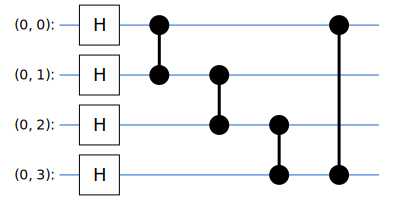

In [10]:
SVGCircuit(cluster_state_circuit(cirq.GridQubit.rect(1, 4)))

In [0]:
def one_qubit_unitary(bit, symbols):
    """Make a Cirq circuit enacting a rotation of the bloch sphere about the X,
    Y and Z axis, that depends on the values in `symbols`.
    """
    return cirq.Circuit(
        cirq.X(bit)**symbols[0],
        cirq.Y(bit)**symbols[1],
        cirq.Z(bit)**symbols[2])


def two_qubit_unitary(bits, symbols):
    """Make a Cirq circuit that creates an arbitrary two qubit unitary."""
    circuit = cirq.Circuit()
    circuit += one_qubit_unitary(bits[0], symbols[0:3])
    circuit += one_qubit_unitary(bits[1], symbols[3:6])
    circuit += [cirq.ZZ(*bits)**symbols[6]]
    circuit += [cirq.YY(*bits)**symbols[7]]
    circuit += [cirq.XX(*bits)**symbols[8]]
    circuit += one_qubit_unitary(bits[0], symbols[9:12])
    circuit += one_qubit_unitary(bits[1], symbols[12:])
    return circuit


def two_qubit_pool(source_qubit, sink_qubit, symbols):
    """Make a Cirq circuit to do a parameterized 'pooling' operation, which
    attempts to reduce entanglement down from two qubits to just one."""
    pool_circuit = cirq.Circuit()
    sink_basis_selector = one_qubit_unitary(sink_qubit, symbols[0:3])
    source_basis_selector = one_qubit_unitary(source_qubit, symbols[3:6])
    pool_circuit.append(sink_basis_selector)
    pool_circuit.append(source_basis_selector)
    pool_circuit.append(cirq.CNOT(control=source_qubit, target=sink_qubit))
    pool_circuit.append(sink_basis_selector**-1)
    return pool_circuit

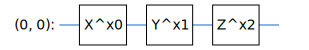

In [12]:
SVGCircuit(one_qubit_unitary(cirq.GridQubit(0, 0), sympy.symbols('x0:3')))

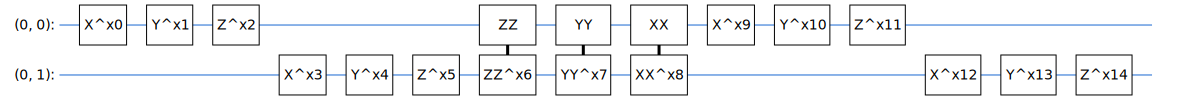

In [13]:
SVGCircuit(two_qubit_unitary(cirq.GridQubit.rect(1, 2), sympy.symbols('x0:15')))

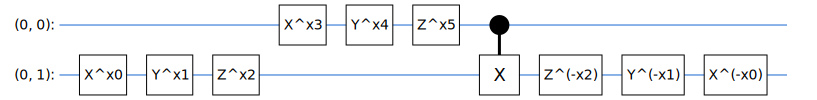

In [14]:
SVGCircuit(two_qubit_pool(*cirq.GridQubit.rect(1, 2), sympy.symbols('x0:6')))

In [0]:
def quantum_conv_circuit(bits, symbols):
    """Quantum Convolution Layer following the above diagram.
    Return a Cirq circuit with the cascade of `two_qubit_unitary` applied
    to all pairs of qubits in `bits` as in the diagram above.
    """
    circuit = cirq.Circuit()
    for first, second in zip(bits[0::2], bits[1::2]):
        circuit += two_qubit_unitary([first, second], symbols)
    for first, second in zip(bits[1::2], bits[2::2] + [bits[0]]):
        circuit += two_qubit_unitary([first, second], symbols)
    return circuit

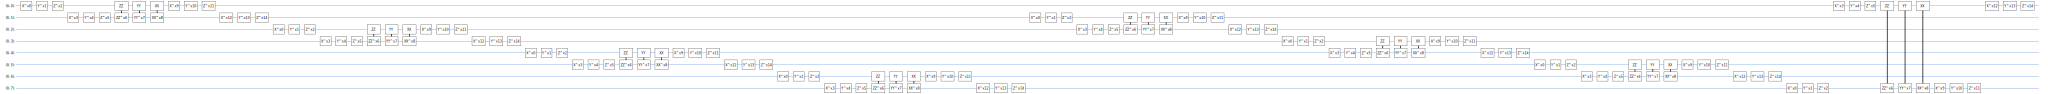

In [16]:
SVGCircuit(quantum_conv_circuit(cirq.GridQubit.rect(1, 8), sympy.symbols('x0:15')))

In [0]:
def quantum_pool_circuit(source_bits, sink_bits, symbols):
    """A layer that specifies a quantum pooling operation.
    A Quantum pool tries to learn to pool the relevant information from two
    qubits onto 1.
    """
    circuit = cirq.Circuit()
    for source, sink in zip(source_bits, sink_bits):
        circuit += two_qubit_pool(source, sink, symbols)
    return circuit

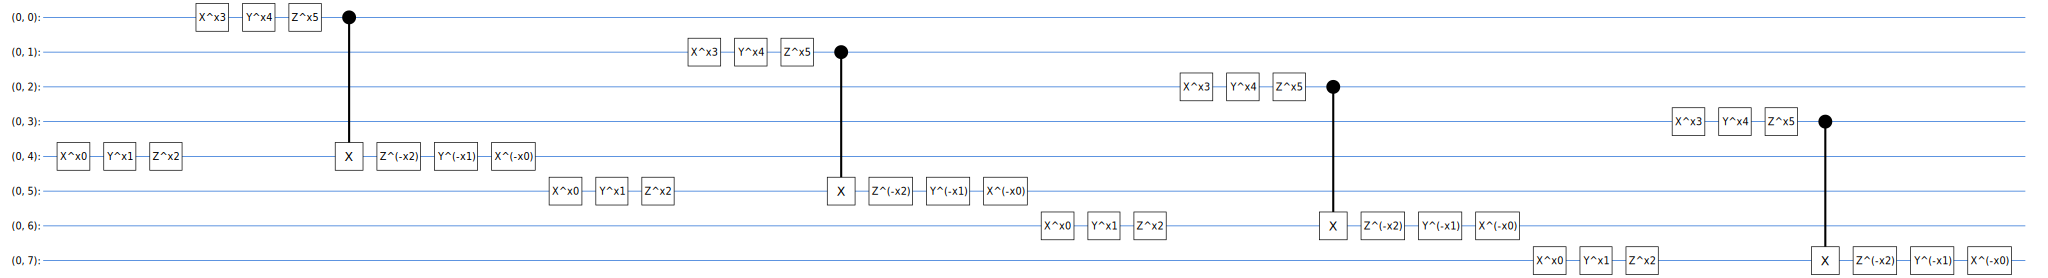

In [18]:
test_bits = cirq.GridQubit.rect(1, 8)

SVGCircuit(quantum_pool_circuit(test_bits[:4], test_bits[4:], sympy.symbols('x0:6')))

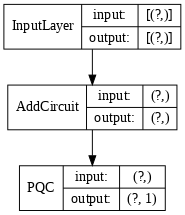

In [19]:
def create_model_circuit(qubits):
    """Create sequence of alternating convolution and pooling operators 
    which gradually shrink over time."""
    model_circuit = cirq.Circuit()
    symbols = sympy.symbols('qconv0:63')
    # Cirq uses sympy.Symbols to map learnable variables. TensorFlow Quantum
    # scans incoming circuits and replaces these with TensorFlow variables.
    model_circuit += quantum_conv_circuit(qubits, symbols[0:15])
    model_circuit += quantum_pool_circuit(qubits[:4], qubits[4:],
                                          symbols[15:21])
    model_circuit += quantum_conv_circuit(qubits[4:], symbols[21:36])
    model_circuit += quantum_pool_circuit(qubits[4:6], qubits[6:],
                                          symbols[36:42])
    model_circuit += quantum_conv_circuit(qubits[6:], symbols[42:57])
    model_circuit += quantum_pool_circuit([qubits[6]], [qubits[7]],
                                          symbols[57:63])
    return model_circuit


# Create our qubits and readout operators in Cirq.
cluster_state_bits = cirq.GridQubit.rect(1, 8)
readout_operators = cirq.Z(cluster_state_bits[-1])

# Build a sequential model enacting the logic in 1.3 of this notebook.
# Here you are making the static cluster state prep as a part of the AddCircuit and the
# "quantum datapoints" are coming in the form of excitation
excitation_input = tf.keras.Input(shape=(), dtype=tf.dtypes.string)
cluster_state = tfq.layers.AddCircuit()(
    excitation_input, prepend=cluster_state_circuit(cluster_state_bits))

quantum_model = tfq.layers.PQC(create_model_circuit(cluster_state_bits),
                               readout_operators)(cluster_state)

qcnn_model = tf.keras.Model(inputs=[excitation_input], outputs=[quantum_model])

# Show the keras plot of the model
tf.keras.utils.plot_model(qcnn_model,
                          show_shapes=True,
                          show_layer_names=False,
                          dpi=70)

In [20]:
# Generate some training data.
train_excitations, train_labels, test_excitations, test_labels = generate_data(
    cluster_state_bits)


# Custom accuracy metric.
@tf.function
def custom_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true)
    y_pred = tf.map_fn(lambda x: 1.0 if x >= 0 else -1.0, y_pred)
    return tf.keras.backend.mean(tf.keras.backend.equal(y_true, y_pred))


qcnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.02),
                   loss=tf.losses.mse,
                   metrics=[custom_accuracy])

history = qcnn_model.fit(x=train_excitations,
                         y=train_labels,
                         batch_size=16,
                         epochs=25,
                         verbose=1,
                         validation_data=(test_excitations, test_labels))

Train on 112 samples, validate on 48 samples
Epoch 1/25
112/112 [==============================] - 17s 154ms/sample - loss: 0.9727 - custom_accuracy: 0.6339 - val_loss: 0.9181 - val_custom_accuracy: 0.6042
Epoch 2/25
112/112 [==============================] - 14s 125ms/sample - loss: 0.8593 - custom_accuracy: 0.6786 - val_loss: 0.8393 - val_custom_accuracy: 0.6667
Epoch 3/25
112/112 [==============================] - 14s 126ms/sample - loss: 0.8127 - custom_accuracy: 0.6518 - val_loss: 0.8088 - val_custom_accuracy: 0.7500
Epoch 4/25
112/112 [==============================] - 14s 126ms/sample - loss: 0.7684 - custom_accuracy: 0.7857 - val_loss: 0.8030 - val_custom_accuracy: 0.7708
Epoch 5/25
112/112 [==============================] - 14s 127ms/sample - loss: 0.7633 - custom_accuracy: 0.7500 - val_loss: 0.7784 - val_custom_accuracy: 0.7292
Epoch 6/25
112/112 [==============================] - 14s 127ms/sample - loss: 0.7406 - custom_accuracy: 0.7589 - val_loss: 0.7567 - val_custom_accura

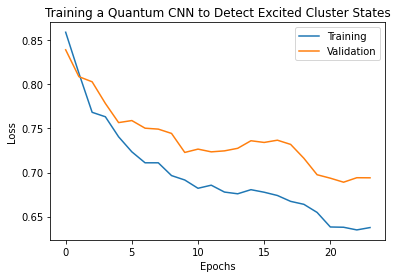

In [21]:
plt.plot(history.history['loss'][1:], label='Training')
plt.plot(history.history['val_loss'][1:], label='Validation')
plt.title('Training a Quantum CNN to Detect Excited Cluster States')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

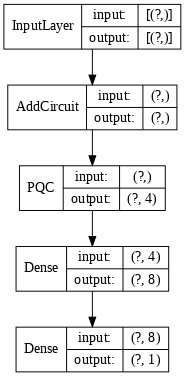

In [22]:
# 1-local operators to read out
readouts = [cirq.Z(bit) for bit in cluster_state_bits[4:]]


def multi_readout_model_circuit(qubits):
    """Make a model circuit with less quantum pool and conv operations."""
    model_circuit = cirq.Circuit()
    symbols = sympy.symbols('qconv0:21')
    model_circuit += quantum_conv_circuit(qubits, symbols[0:15])
    model_circuit += quantum_pool_circuit(qubits[:4], qubits[4:],
                                          symbols[15:21])
    return model_circuit


# Build a model enacting the logic in 2.1 of this notebook.
excitation_input_dual = tf.keras.Input(shape=(), dtype=tf.dtypes.string)

cluster_state_dual = tfq.layers.AddCircuit()(
    excitation_input_dual, prepend=cluster_state_circuit(cluster_state_bits))

quantum_model_dual = tfq.layers.PQC(
    multi_readout_model_circuit(cluster_state_bits),
    readouts)(cluster_state_dual)

d1_dual = tf.keras.layers.Dense(8)(quantum_model_dual)

d2_dual = tf.keras.layers.Dense(1)(d1_dual)

hybrid_model = tf.keras.Model(inputs=[excitation_input_dual], outputs=[d2_dual])

# Display the model architecture
tf.keras.utils.plot_model(hybrid_model,
                          show_shapes=True,
                          show_layer_names=False,
                          dpi=70)

In [23]:
hybrid_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.02),
                     loss=tf.losses.mse,
                     metrics=[custom_accuracy])

hybrid_history = hybrid_model.fit(x=train_excitations,
                                  y=train_labels,
                                  batch_size=16,
                                  epochs=25,
                                  verbose=1,
                                  validation_data=(test_excitations,
                                                   test_labels))

Train on 112 samples, validate on 48 samples
Epoch 1/25
112/112 [==============================] - 4s 38ms/sample - loss: 0.9581 - custom_accuracy: 0.4821 - val_loss: 0.8901 - val_custom_accuracy: 0.5625
Epoch 2/25
112/112 [==============================] - 3s 30ms/sample - loss: 0.7845 - custom_accuracy: 0.7589 - val_loss: 0.6527 - val_custom_accuracy: 0.7917
Epoch 3/25
112/112 [==============================] - 3s 30ms/sample - loss: 0.5532 - custom_accuracy: 0.8036 - val_loss: 0.4631 - val_custom_accuracy: 0.9375
Epoch 4/25
112/112 [==============================] - 3s 30ms/sample - loss: 0.3646 - custom_accuracy: 0.9107 - val_loss: 0.2562 - val_custom_accuracy: 0.9583
Epoch 5/25
112/112 [==============================] - 3s 30ms/sample - loss: 0.2336 - custom_accuracy: 0.9643 - val_loss: 0.2070 - val_custom_accuracy: 0.9583
Epoch 6/25
112/112 [==============================] - 3s 30ms/sample - loss: 0.2055 - custom_accuracy: 0.9732 - val_loss: 0.2741 - val_custom_accuracy: 0.9375
E

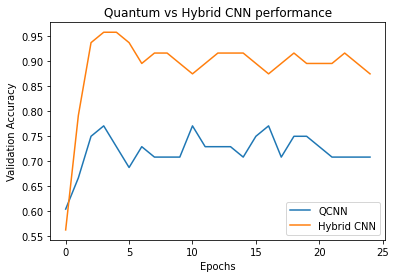

In [24]:
plt.plot(history.history['val_custom_accuracy'], label='QCNN')
plt.plot(hybrid_history.history['val_custom_accuracy'], label='Hybrid CNN')
plt.title('Quantum vs Hybrid CNN performance')
plt.xlabel('Epochs')
plt.legend()
plt.ylabel('Validation Accuracy')
plt.show()

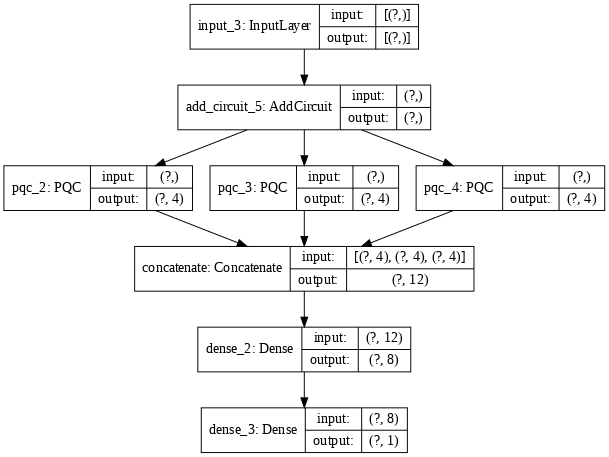

In [25]:
excitation_input_multi = tf.keras.Input(shape=(), dtype=tf.dtypes.string)

cluster_state_multi = tfq.layers.AddCircuit()(
    excitation_input_multi, prepend=cluster_state_circuit(cluster_state_bits))

# apply 3 different filters and measure expectation values

quantum_model_multi1 = tfq.layers.PQC(
    multi_readout_model_circuit(cluster_state_bits),
    readouts)(cluster_state_multi)

quantum_model_multi2 = tfq.layers.PQC(
    multi_readout_model_circuit(cluster_state_bits),
    readouts)(cluster_state_multi)

quantum_model_multi3 = tfq.layers.PQC(
    multi_readout_model_circuit(cluster_state_bits),
    readouts)(cluster_state_multi)

# concatenate outputs and feed into a small classical NN
concat_out = tf.keras.layers.concatenate(
    [quantum_model_multi1, quantum_model_multi2, quantum_model_multi3])

dense_1 = tf.keras.layers.Dense(8)(concat_out)

dense_2 = tf.keras.layers.Dense(1)(dense_1)

multi_qconv_model = tf.keras.Model(inputs=[excitation_input_multi],
                                   outputs=[dense_2])

# Display the model architecture
tf.keras.utils.plot_model(multi_qconv_model,
                          show_shapes=True,
                          show_layer_names=True,
                          dpi=70)

In [26]:
multi_qconv_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.02),
    loss=tf.losses.mse,
    metrics=[custom_accuracy])

multi_qconv_history = multi_qconv_model.fit(x=train_excitations,
                                            y=train_labels,
                                            batch_size=16,
                                            epochs=25,
                                            verbose=1,
                                            validation_data=(test_excitations,
                                                             test_labels))

Train on 112 samples, validate on 48 samples
Epoch 1/25
112/112 [==============================] - 12s 103ms/sample - loss: 0.6911 - custom_accuracy: 0.7679 - val_loss: 0.3182 - val_custom_accuracy: 0.9375
Epoch 2/25
112/112 [==============================] - 10s 87ms/sample - loss: 0.2642 - custom_accuracy: 0.9286 - val_loss: 0.2856 - val_custom_accuracy: 0.9375
Epoch 3/25
112/112 [==============================] - 10s 88ms/sample - loss: 0.2291 - custom_accuracy: 0.9821 - val_loss: 0.2262 - val_custom_accuracy: 0.9583
Epoch 4/25
112/112 [==============================] - 10s 87ms/sample - loss: 0.2041 - custom_accuracy: 0.9821 - val_loss: 0.2427 - val_custom_accuracy: 0.8958
Epoch 5/25
112/112 [==============================] - 10s 87ms/sample - loss: 0.1858 - custom_accuracy: 0.9821 - val_loss: 0.2413 - val_custom_accuracy: 0.9167
Epoch 6/25
112/112 [==============================] - 10s 88ms/sample - loss: 0.1752 - custom_accuracy: 0.9911 - val_loss: 0.2221 - val_custom_accuracy: 0

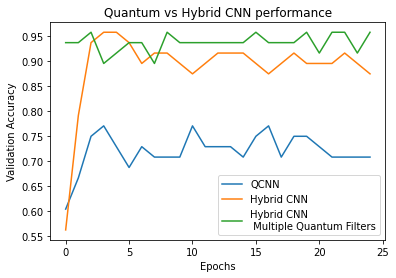

In [27]:
plt.plot(history.history['val_custom_accuracy'][:25], label='QCNN')
plt.plot(hybrid_history.history['val_custom_accuracy'][:25], label='Hybrid CNN')
plt.plot(multi_qconv_history.history['val_custom_accuracy'][:25],
         label='Hybrid CNN \n Multiple Quantum Filters')
plt.title('Quantum vs Hybrid CNN performance')
plt.xlabel('Epochs')
plt.legend()
plt.ylabel('Validation Accuracy')
plt.show()